In [1]:
# ==============================================================================
#
#     Procedural Time Series Model Analysis with Detailed Hyperparameters
#
# This script trains and evaluates seven deep learning models (TCN, LSTM, BiLSTM, GRU, BiGRU, GCN, InformerGCN).
#
# KEY FEATURES OF THIS VERSION:
# - Each model has a dedicated section with EXPLICITLY COMMENTED hyperparameters
#   to make understanding and tuning easy.
# - The training loop provides a verbose log for each epoch.
# - R-squared (R²), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE)
#   are now calculated for all models.
# - A final section plots all training losses and individual train vs. val losses.
#
# ==============================================================================


# ==============================================================================
# Part 1: Global Setup and Data Preprocessing
# ==============================================================================

# --- Step 1.1: Import Necessary Libraries ---
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import itertools
import math

print("Libraries imported successfully.\n")


# --- Step 1.2: Load the Dataset ---
print("\nLoading the dataset...")
# !!! IMPORTANT: Update this file path to match the location of your CSV file.
try:
    file_path = "B.csv"
    df = pd.read_csv(file_path)
    print(f"Dataset loaded. Initial shape: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: The file '{file_path}' was not found.")
    print("Creating a dummy dataset for demonstration purposes.")
    data = {'Date & Time': pd.to_datetime(pd.date_range(start='1/1/2022', periods=10000, freq='h')),'Total': np.random.randn(10000).cumsum() + 50}
    df = pd.DataFrame(data)
    for i in range(14): df[f'F{i}'] = np.random.rand(10000)

# --- Step 1.3: Preprocess the Data ---
print("\nPreprocessing 'Date & Time' and handling missing values...")
df["Date & Time"] = pd.to_datetime(df["Date & Time"], errors='coerce', infer_datetime_format=True)
df.dropna(inplace=True)
print(f"DataFrame shape after cleaning: {df.shape}")


# --- Step 1.4: Feature Engineering ---
print("\nExtracting time-based features (hour, dayofweek, month)...")
df["hour"] = df["Date & Time"].dt.hour
df["dayofweek"] = df["Date & Time"].dt.dayofweek
df["month"] = df["Date & Time"].dt.month


# --- Step 1.5: Separate Features and Target ---
print("\nSeparating features and target variable...")
if "Total" not in df.columns: df['Total'] = df.iloc[:, 1]
features = df.drop(columns=["Date & Time", "Total"])
target = df["Total"]


# --- Step 1.6: Normalize the Data ---
print("\nScaling features and target to the [0, 1] range...")
feature_scaler = MinMaxScaler(); target_scaler = MinMaxScaler()
features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))


# --- Step 1.7: Create Time Series Sequences ---
# HYPERPARAMETER: The length of the input sequence for the models.
SEQ_LEN = 48
print(f"\nCreating sequences of length {SEQ_LEN}...")
X, Y = [], []
for i in range(len(features_scaled) - SEQ_LEN):
    X.append(features_scaled[i:i + SEQ_LEN])
    Y.append(target_scaled[i + SEQ_LEN - 1])
X, Y = np.array(X), np.array(Y)
print(f"Shape of X (sequences): {X.shape}, Shape of Y (targets): {Y.shape}")


# --- Step 1.8: Split Data into Training, Validation, and Test Sets ---
print("\nSplitting the data into train (70%), validation (15%), and test (15%) sets...")
train_size, val_size = int(0.7 * len(X)), int(0.15 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size + val_size], Y[train_size:train_size + val_size]
X_test, Y_test = X[train_size + val_size:], Y[train_size + val_size:]
print(f"Train shapes: {X_train.shape}, {Y_train.shape}")
print(f"Validation shapes: {X_val.shape}, {Y_val.shape}")
print(f"Test shapes: {X_test.shape}, {Y_test.shape}")


# --- Step 1.9: Convert Data to PyTorch Tensors ---
print("\nConverting NumPy arrays to PyTorch tensors...")
X_train = torch.tensor(X_train, dtype=torch.float32); Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32); Y_val = torch.tensor(Y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32); Y_test = torch.tensor(Y_test, dtype=torch.float32)


# --- Step 1.10: Set Up Computation Device and History Dictionaries ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nComputation device set to: {device}")
loss_history, val_loss_history, r2_scores, rmse_scores, mae_scores = {}, {}, {}, {}, {}
print("Initialized dictionaries to store training/validation loss and final metrics.")


# --- Step 1.11: Create Adjacency Matrix for GCN Models ---
print("\nCreating correlation-based adjacency matrix for GCN models...")
CORR_THRESHOLD = 0.5
correlation_matrix = features.corr()
adj = (np.abs(correlation_matrix) > CORR_THRESHOLD).astype(float)
adj_tensor = torch.tensor(adj.values, dtype=torch.float32).to(device)
print("Adjacency matrix created with shape:", adj_tensor.shape)


# ==============================================================================
# Part 2 to 6: Standard RNN and TCN Models (Unchanged)
# ==============================================================================


Libraries imported successfully.


Loading the dataset...
Dataset loaded. Initial shape: (50000, 10)

Preprocessing 'Date & Time' and handling missing values...


C:\Users\impra\AppData\Local\Temp\ipykernel_13480\3662652468.py:54: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["Date & Time"] = pd.to_datetime(df["Date & Time"], errors='coerce', infer_datetime_format=True)
C:\Users\impra\AppData\Local\Temp\ipykernel_13480\3662652468.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date & Time"] = pd.to_datetime(df["Date & Time"], errors='coerce', infer_datetime_format=True)


DataFrame shape after cleaning: (50000, 10)

Extracting time-based features (hour, dayofweek, month)...

Separating features and target variable...

Scaling features and target to the [0, 1] range...

Creating sequences of length 48...
Shape of X (sequences): (49952, 48, 11), Shape of Y (targets): (49952, 1)

Splitting the data into train (70%), validation (15%), and test (15%) sets...
Train shapes: (34966, 48, 11), (34966, 1)
Validation shapes: (7492, 48, 11), (7492, 1)
Test shapes: (7494, 48, 11), (7494, 1)

Converting NumPy arrays to PyTorch tensors...

Computation device set to: cuda
Initialized dictionaries to store training/validation loss and final metrics.

Creating correlation-based adjacency matrix for GCN models...
Adjacency matrix created with shape: torch.Size([11, 11])




PART 2: PROCEDURAL TCN

--- Starting TCN Model Training ---
TCN Epoch  1/20 | Train Loss: 0.004799 | Val Loss: 0.000558
TCN Epoch  2/20 | Train Loss: 0.000168 | Val Loss: 0.000197
TCN Epoch  3/20 | Train Loss: 0.000038 | Val Loss: 0.000103
TCN Epoch  4/20 | Train Loss: 0.000021 | Val Loss: 0.000090
TCN Epoch  5/20 | Train Loss: 0.000012 | Val Loss: 0.000121
TCN Epoch  6/20 | Train Loss: 0.000012 | Val Loss: 0.000092
TCN Epoch  7/20 | Train Loss: 0.000009 | Val Loss: 0.000067
TCN Epoch  8/20 | Train Loss: 0.000009 | Val Loss: 0.000048
TCN Epoch  9/20 | Train Loss: 0.000005 | Val Loss: 0.000041
TCN Epoch 10/20 | Train Loss: 0.000006 | Val Loss: 0.000024
TCN Epoch 11/20 | Train Loss: 0.000005 | Val Loss: 0.000014
TCN Epoch 12/20 | Train Loss: 0.000004 | Val Loss: 0.000018
TCN Epoch 13/20 | Train Loss: 0.000006 | Val Loss: 0.000011
TCN Epoch 14/20 | Train Loss: 0.000003 | Val Loss: 0.000013
TCN Epoch 15/20 | Train Loss: 0.000003 | Val Loss: 0.000013
TCN Epoch 16/20 | Train Loss: 0.000003

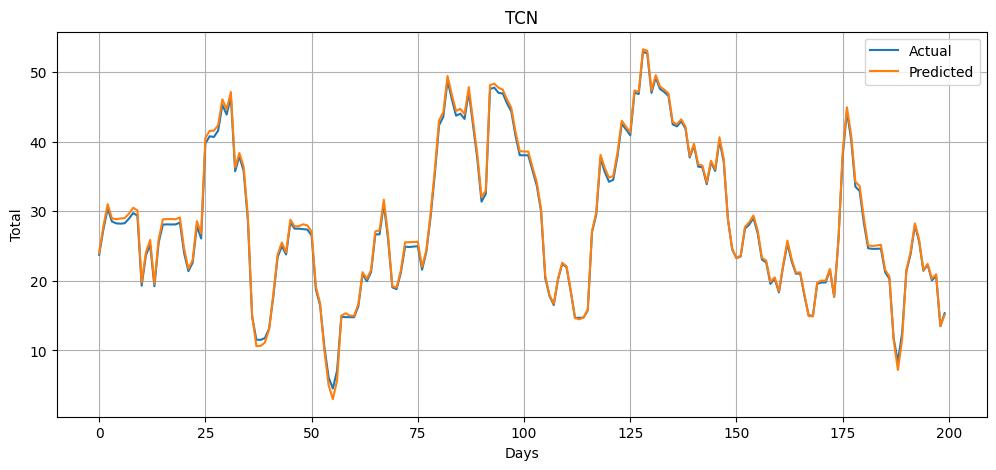

In [2]:

# --- Part 2: TCN ---
print("\n\n" + "=" * 60); print("PART 2: PROCEDURAL TCN"); print("=" * 60)
TCN_INPUT_DIM, TCN_CHANNELS, TCN_OUTPUT_DIM = X_train.shape[2], 64, 1
TCN_KERNEL_SIZE_1, TCN_KERNEL_SIZE_2 = 7, 5
TCN_EPOCHS, TCN_BATCH_SIZE, TCN_LEARNING_RATE = 20, 32, 0.001
tcn_conv_stack = nn.Sequential(nn.Conv1d(TCN_INPUT_DIM, TCN_CHANNELS, TCN_KERNEL_SIZE_1, padding=(TCN_KERNEL_SIZE_1-1)//2), nn.ReLU(), nn.Conv1d(TCN_CHANNELS, TCN_CHANNELS, TCN_KERNEL_SIZE_2, padding=(TCN_KERNEL_SIZE_2-1)//2), nn.ReLU(), nn.AdaptiveAvgPool1d(1)).to(device)
tcn_fc_layer = nn.Linear(TCN_CHANNELS, TCN_OUTPUT_DIM).to(device)
tcn_optimizer = torch.optim.Adam(itertools.chain(tcn_conv_stack.parameters(), tcn_fc_layer.parameters()), lr=TCN_LEARNING_RATE)
tcn_criterion = nn.MSELoss(); tcn_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=TCN_BATCH_SIZE, shuffle=True)
loss_history['TCN'], val_loss_history['TCN'] = [], []
print("\n--- Starting TCN Model Training ---")
for epoch in range(TCN_EPOCHS):
    tcn_conv_stack.train(); tcn_fc_layer.train(); running_loss = 0.0
    for xb, yb in tcn_train_loader:
        xb, yb = xb.to(device), yb.to(device); features = tcn_conv_stack(xb.permute(0, 2, 1)); pred = tcn_fc_layer(features.squeeze(-1)); loss = tcn_criterion(pred, yb); tcn_optimizer.zero_grad(); loss.backward(); tcn_optimizer.step(); running_loss += loss.item()
    avg_epoch_loss = running_loss / len(tcn_train_loader); loss_history['TCN'].append(avg_epoch_loss)
    with torch.no_grad(): val_features = tcn_conv_stack(X_val.to(device).permute(0, 2, 1)); val_pred = tcn_fc_layer(val_features.squeeze(-1)); val_loss = tcn_criterion(val_pred, Y_val.to(device)); val_loss_history['TCN'].append(val_loss.item())
    print(f"TCN Epoch {epoch+1:2d}/{TCN_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss.item():.6f}")
print("--- TCN Training Complete ---")
with torch.no_grad(): tcn_preds_rescaled = target_scaler.inverse_transform(tcn_fc_layer(tcn_conv_stack(X_test.to(device).permute(0, 2, 1)).squeeze(-1)).cpu().numpy()); tcn_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())
tcn_r2, tcn_rmse, tcn_mae = r2_score(tcn_true_rescaled, tcn_preds_rescaled), np.sqrt(mean_squared_error(tcn_true_rescaled, tcn_preds_rescaled)), mean_absolute_error(tcn_true_rescaled, tcn_preds_rescaled)
r2_scores['TCN'], rmse_scores['TCN'], mae_scores['TCN'] = tcn_r2, tcn_rmse, tcn_mae
print(f"\nTCN Final R²: {tcn_r2:.4f}, RMSE: {tcn_rmse:.4f}, MAE: {tcn_mae:.4f}")
plt.figure(figsize=(12, 5)); plt.plot(tcn_true_rescaled[:200], label='Actual'); plt.plot(tcn_preds_rescaled[:200], label='Predicted'); plt.title('TCN');
plt.xlabel("Days")
plt.ylabel("Total")
plt.legend(); plt.grid(True); plt.show()




PART 3: PROCEDURAL UNIDIRECTIONAL LSTM

--- Starting LSTM Model Training ---
LSTM Epoch  1/20 | Train Loss: 0.001569 | Val Loss: 0.000166
LSTM Epoch  2/20 | Train Loss: 0.000005 | Val Loss: 0.000168
LSTM Epoch  3/20 | Train Loss: 0.000003 | Val Loss: 0.000122
LSTM Epoch  4/20 | Train Loss: 0.000003 | Val Loss: 0.000116
LSTM Epoch  5/20 | Train Loss: 0.000002 | Val Loss: 0.000094
LSTM Epoch  6/20 | Train Loss: 0.000002 | Val Loss: 0.000070
LSTM Epoch  7/20 | Train Loss: 0.000001 | Val Loss: 0.000068
LSTM Epoch  8/20 | Train Loss: 0.000001 | Val Loss: 0.000049
LSTM Epoch  9/20 | Train Loss: 0.000001 | Val Loss: 0.000057
LSTM Epoch 10/20 | Train Loss: 0.000001 | Val Loss: 0.000036
LSTM Epoch 11/20 | Train Loss: 0.000001 | Val Loss: 0.000032
LSTM Epoch 12/20 | Train Loss: 0.000001 | Val Loss: 0.000035
LSTM Epoch 13/20 | Train Loss: 0.000001 | Val Loss: 0.000026
LSTM Epoch 14/20 | Train Loss: 0.000001 | Val Loss: 0.000031
LSTM Epoch 15/20 | Train Loss: 0.000001 | Val Loss: 0.000031
LSTM E

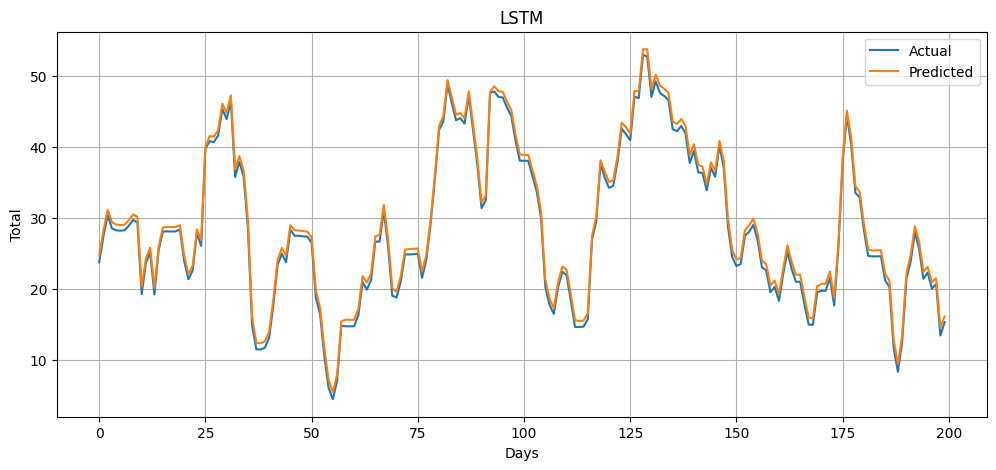

In [3]:

# --- Part 3: LSTM ---
print("\n\n" + "=" * 60); print("PART 3: PROCEDURAL UNIDIRECTIONAL LSTM"); print("=" * 60)
LSTM_INPUT_DIM, LSTM_HIDDEN_DIM, LSTM_NUM_LAYERS, LSTM_OUTPUT_DIM, LSTM_DROPOUT = X_train.shape[2], 64, 1, 1, 0.0
LSTM_EPOCHS, LSTM_BATCH_SIZE, LSTM_LEARNING_RATE = 20, 32, 0.001
lstm_layer = nn.LSTM(LSTM_INPUT_DIM, LSTM_HIDDEN_DIM, LSTM_NUM_LAYERS, batch_first=True, dropout=LSTM_DROPOUT).to(device)
lstm_fc_layer = nn.Linear(LSTM_HIDDEN_DIM, LSTM_OUTPUT_DIM).to(device); lstm_optimizer = torch.optim.Adam(itertools.chain(lstm_layer.parameters(), lstm_fc_layer.parameters()), lr=LSTM_LEARNING_RATE)
lstm_criterion = nn.MSELoss(); lstm_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=LSTM_BATCH_SIZE, shuffle=True); loss_history['LSTM'], val_loss_history['LSTM'] = [], []
print("\n--- Starting LSTM Model Training ---")
for epoch in range(LSTM_EPOCHS):
    lstm_layer.train(); lstm_fc_layer.train(); running_loss = 0.0
    for xb, yb in lstm_train_loader:
        xb, yb = xb.to(device), yb.to(device); rnn_out, _ = lstm_layer(xb); pred = lstm_fc_layer(rnn_out[:, -1, :]); loss = lstm_criterion(pred, yb); lstm_optimizer.zero_grad(); loss.backward(); lstm_optimizer.step(); running_loss += loss.item()
    avg_epoch_loss = running_loss / len(lstm_train_loader); loss_history['LSTM'].append(avg_epoch_loss)
    with torch.no_grad(): rnn_out, _ = lstm_layer(X_val.to(device)); val_pred = lstm_fc_layer(rnn_out[:, -1, :]); val_loss = lstm_criterion(val_pred, Y_val.to(device)); val_loss_history['LSTM'].append(val_loss.item())
    print(f"LSTM Epoch {epoch+1:2d}/{LSTM_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss.item():.6f}")
print("--- LSTM Training Complete ---")
with torch.no_grad(): rnn_out, _ = lstm_layer(X_test.to(device)); lstm_preds_rescaled = target_scaler.inverse_transform(lstm_fc_layer(rnn_out[:, -1, :]).cpu().numpy()); lstm_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())
lstm_r2, lstm_rmse, lstm_mae = r2_score(lstm_true_rescaled, lstm_preds_rescaled), np.sqrt(mean_squared_error(lstm_true_rescaled, lstm_preds_rescaled)), mean_absolute_error(lstm_true_rescaled, lstm_preds_rescaled)
r2_scores['LSTM'], rmse_scores['LSTM'], mae_scores['LSTM'] = lstm_r2, lstm_rmse, lstm_mae
print(f"\nLSTM Final R²: {lstm_r2:.4f}, RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}")
plt.figure(figsize=(12, 5)); plt.plot(lstm_true_rescaled[:200], label='Actual'); plt.plot(lstm_preds_rescaled[:200], label='Predicted'); plt.title('LSTM');
plt.xlabel("Days")
plt.ylabel("Total")
plt.legend(); plt.grid(True); plt.show()




PART 4: PROCEDURAL BIDIRECTIONAL LSTM (BILSTM)

--- Starting BiLSTM Model Training ---
BiLSTM Epoch  1/20 | Train Loss: 0.001205 | Val Loss: 0.001168
BiLSTM Epoch  2/20 | Train Loss: 0.000003 | Val Loss: 0.001027
BiLSTM Epoch  3/20 | Train Loss: 0.000002 | Val Loss: 0.001010
BiLSTM Epoch  4/20 | Train Loss: 0.000001 | Val Loss: 0.000959
BiLSTM Epoch  5/20 | Train Loss: 0.000001 | Val Loss: 0.000914
BiLSTM Epoch  6/20 | Train Loss: 0.000001 | Val Loss: 0.000772
BiLSTM Epoch  7/20 | Train Loss: 0.000001 | Val Loss: 0.000718
BiLSTM Epoch  8/20 | Train Loss: 0.000001 | Val Loss: 0.000637
BiLSTM Epoch  9/20 | Train Loss: 0.000001 | Val Loss: 0.000577
BiLSTM Epoch 10/20 | Train Loss: 0.000001 | Val Loss: 0.000508
BiLSTM Epoch 11/20 | Train Loss: 0.000001 | Val Loss: 0.000476
BiLSTM Epoch 12/20 | Train Loss: 0.000001 | Val Loss: 0.000425
BiLSTM Epoch 13/20 | Train Loss: 0.000001 | Val Loss: 0.000384
BiLSTM Epoch 14/20 | Train Loss: 0.000001 | Val Loss: 0.000346
BiLSTM Epoch 15/20 | Train Lo

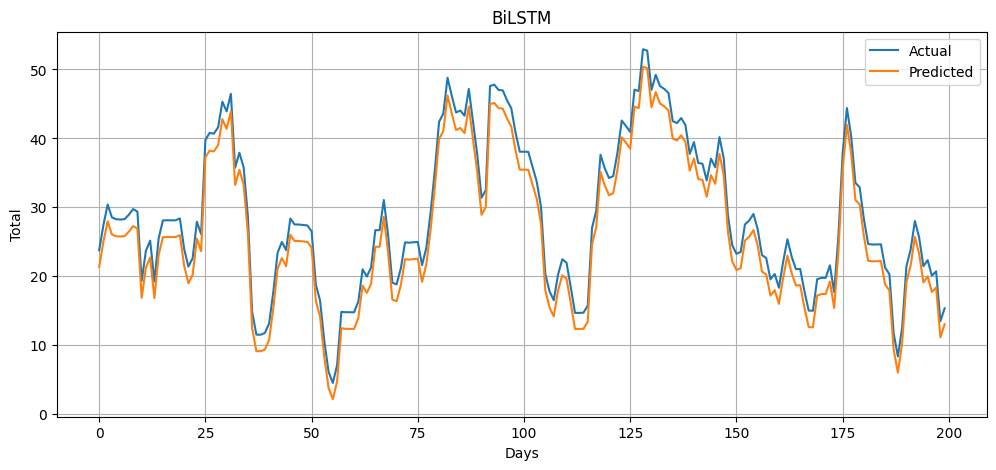

In [4]:

# --- Part 4: BiLSTM ---
print("\n\n" + "=" * 60); print("PART 4: PROCEDURAL BIDIRECTIONAL LSTM (BILSTM)"); print("=" * 60)
BILSTM_INPUT_DIM, BILSTM_HIDDEN_DIM, BILSTM_NUM_LAYERS, BILSTM_OUTPUT_DIM, BILSTM_DROPOUT = X_train.shape[2], 64, 1, 1, 0.0
BILSTM_EPOCHS, BILSTM_BATCH_SIZE, BILSTM_LEARNING_RATE = 20, 32, 0.001
bilstm_layer = nn.LSTM(BILSTM_INPUT_DIM, BILSTM_HIDDEN_DIM, BILSTM_NUM_LAYERS, batch_first=True, bidirectional=True, dropout=BILSTM_DROPOUT).to(device)
bilstm_fc_layer = nn.Linear(BILSTM_HIDDEN_DIM * 2, BILSTM_OUTPUT_DIM).to(device); bilstm_optimizer = torch.optim.Adam(itertools.chain(bilstm_layer.parameters(), bilstm_fc_layer.parameters()), lr=BILSTM_LEARNING_RATE)
bilstm_criterion = nn.MSELoss(); bilstm_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BILSTM_BATCH_SIZE, shuffle=True); loss_history['BiLSTM'], val_loss_history['BiLSTM'] = [], []
print("\n--- Starting BiLSTM Model Training ---")
for epoch in range(BILSTM_EPOCHS):
    bilstm_layer.train(); bilstm_fc_layer.train(); running_loss = 0.0
    for xb, yb in bilstm_train_loader:
        xb, yb = xb.to(device), yb.to(device); rnn_out, _ = bilstm_layer(xb); pred = bilstm_fc_layer(rnn_out[:, -1, :]); loss = bilstm_criterion(pred, yb); bilstm_optimizer.zero_grad(); loss.backward(); bilstm_optimizer.step(); running_loss += loss.item()
    avg_epoch_loss = running_loss / len(bilstm_train_loader); loss_history['BiLSTM'].append(avg_epoch_loss)
    with torch.no_grad(): rnn_out, _ = bilstm_layer(X_val.to(device)); val_pred = bilstm_fc_layer(rnn_out[:, -1, :]); val_loss = bilstm_criterion(val_pred, Y_val.to(device)); val_loss_history['BiLSTM'].append(val_loss.item())
    print(f"BiLSTM Epoch {epoch+1:2d}/{BILSTM_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss.item():.6f}")
print("--- BiLSTM Training Complete ---")
with torch.no_grad(): rnn_out, _ = bilstm_layer(X_test.to(device)); bilstm_preds_rescaled = target_scaler.inverse_transform(bilstm_fc_layer(rnn_out[:, -1, :]).cpu().numpy()); bilstm_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())
bilstm_r2, bilstm_rmse, bilstm_mae = r2_score(bilstm_true_rescaled, bilstm_preds_rescaled), np.sqrt(mean_squared_error(bilstm_true_rescaled, bilstm_preds_rescaled)), mean_absolute_error(bilstm_true_rescaled, bilstm_preds_rescaled)
r2_scores['BiLSTM'], rmse_scores['BiLSTM'], mae_scores['BiLSTM'] = bilstm_r2, bilstm_rmse, bilstm_mae
print(f"\nBiLSTM Final R²: {bilstm_r2:.4f}, RMSE: {bilstm_rmse:.4f}, MAE: {bilstm_mae:.4f}")
plt.figure(figsize=(12, 5)); plt.plot(bilstm_true_rescaled[:200], label='Actual'); plt.plot(bilstm_preds_rescaled[:200], label='Predicted'); plt.title('BiLSTM');
plt.xlabel("Days")
plt.ylabel("Total")
plt.legend(); plt.grid(True); plt.show()




PART 5: PROCEDURAL UNIDIRECTIONAL GRU

--- Starting GRU Model Training ---
GRU Epoch  1/20 | Train Loss: 0.000967 | Val Loss: 0.001278
GRU Epoch  2/20 | Train Loss: 0.000004 | Val Loss: 0.001261
GRU Epoch  3/20 | Train Loss: 0.000002 | Val Loss: 0.001297
GRU Epoch  4/20 | Train Loss: 0.000001 | Val Loss: 0.001399
GRU Epoch  5/20 | Train Loss: 0.000001 | Val Loss: 0.001372
GRU Epoch  6/20 | Train Loss: 0.000002 | Val Loss: 0.001583
GRU Epoch  7/20 | Train Loss: 0.000002 | Val Loss: 0.001351
GRU Epoch  8/20 | Train Loss: 0.000002 | Val Loss: 0.001329
GRU Epoch  9/20 | Train Loss: 0.000001 | Val Loss: 0.001253
GRU Epoch 10/20 | Train Loss: 0.000001 | Val Loss: 0.001258
GRU Epoch 11/20 | Train Loss: 0.000002 | Val Loss: 0.001143
GRU Epoch 12/20 | Train Loss: 0.000001 | Val Loss: 0.001134
GRU Epoch 13/20 | Train Loss: 0.000001 | Val Loss: 0.001083
GRU Epoch 14/20 | Train Loss: 0.000001 | Val Loss: 0.001074
GRU Epoch 15/20 | Train Loss: 0.000002 | Val Loss: 0.001064
GRU Epoch 16/20 | Train

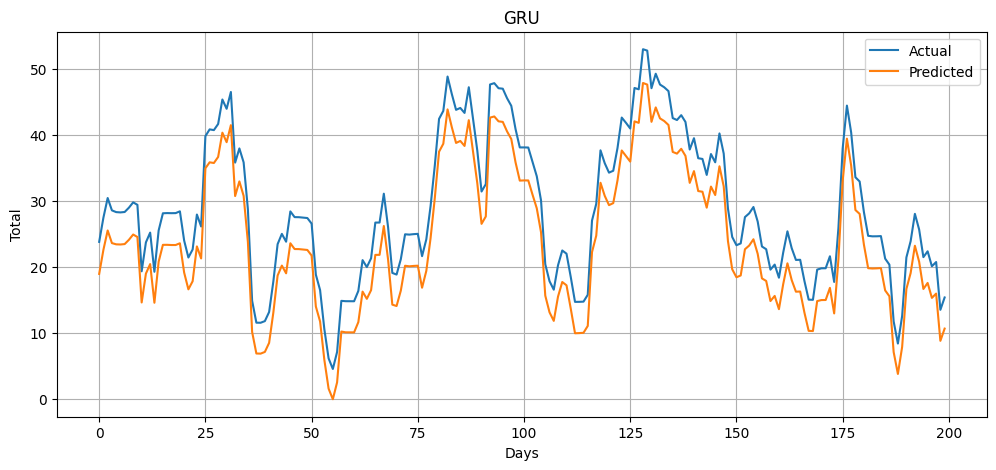

In [5]:

# --- Part 5: GRU ---
print("\n\n" + "=" * 60); print("PART 5: PROCEDURAL UNIDIRECTIONAL GRU"); print("=" * 60)
GRU_INPUT_DIM, GRU_HIDDEN_DIM, GRU_NUM_LAYERS, GRU_OUTPUT_DIM, GRU_DROPOUT = X_train.shape[2], 64, 1, 1, 0.0
GRU_EPOCHS, GRU_BATCH_SIZE, GRU_LEARNING_RATE = 20, 32, 0.001
gru_layer = nn.GRU(GRU_INPUT_DIM, GRU_HIDDEN_DIM, GRU_NUM_LAYERS, batch_first=True, dropout=GRU_DROPOUT).to(device)
gru_fc_layer = nn.Linear(GRU_HIDDEN_DIM, GRU_OUTPUT_DIM).to(device); gru_optimizer = torch.optim.Adam(itertools.chain(gru_layer.parameters(), gru_fc_layer.parameters()), lr=GRU_LEARNING_RATE)
gru_criterion = nn.MSELoss(); gru_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=GRU_BATCH_SIZE, shuffle=True); loss_history['GRU'], val_loss_history['GRU'] = [], []
print("\n--- Starting GRU Model Training ---")
for epoch in range(GRU_EPOCHS):
    gru_layer.train(); gru_fc_layer.train(); running_loss = 0.0
    for xb, yb in gru_train_loader:
        xb, yb = xb.to(device), yb.to(device); rnn_out, _ = gru_layer(xb); pred = gru_fc_layer(rnn_out[:, -1, :]); loss = gru_criterion(pred, yb); gru_optimizer.zero_grad(); loss.backward(); gru_optimizer.step(); running_loss += loss.item()
    avg_epoch_loss = running_loss / len(gru_train_loader); loss_history['GRU'].append(avg_epoch_loss)
    with torch.no_grad(): rnn_out, _ = gru_layer(X_val.to(device)); val_pred = gru_fc_layer(rnn_out[:, -1, :]); val_loss = gru_criterion(val_pred, Y_val.to(device)); val_loss_history['GRU'].append(val_loss.item())
    print(f"GRU Epoch {epoch+1:2d}/{GRU_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss.item():.6f}")
print("--- GRU Training Complete ---")
with torch.no_grad(): rnn_out, _ = gru_layer(X_test.to(device)); gru_preds_rescaled = target_scaler.inverse_transform(gru_fc_layer(rnn_out[:, -1, :]).cpu().numpy()); gru_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())
gru_r2, gru_rmse, gru_mae = r2_score(gru_true_rescaled, gru_preds_rescaled), np.sqrt(mean_squared_error(gru_true_rescaled, gru_preds_rescaled)), mean_absolute_error(gru_true_rescaled, gru_preds_rescaled)
r2_scores['GRU'], rmse_scores['GRU'], mae_scores['GRU'] = gru_r2, gru_rmse, gru_mae
print(f"\nGRU Final R²: {gru_r2:.4f}, RMSE: {gru_rmse:.4f}, MAE: {gru_mae:.4f}")
plt.figure(figsize=(12, 5)); plt.plot(gru_true_rescaled[:200], label='Actual'); plt.plot(gru_preds_rescaled[:200], label='Predicted'); plt.title('GRU');
plt.xlabel("Days")
plt.ylabel("Total")
plt.legend(); plt.grid(True); plt.show()




PART 6: PROCEDURAL BIDIRECTIONAL GRU (BIGRU)

--- Starting BiGRU Model Training ---
BiGRU Epoch  1/20 | Train Loss: 0.000799 | Val Loss: 0.000063
BiGRU Epoch  2/20 | Train Loss: 0.000002 | Val Loss: 0.000058
BiGRU Epoch  3/20 | Train Loss: 0.000001 | Val Loss: 0.000059
BiGRU Epoch  4/20 | Train Loss: 0.000001 | Val Loss: 0.000049
BiGRU Epoch  5/20 | Train Loss: 0.000002 | Val Loss: 0.000054
BiGRU Epoch  6/20 | Train Loss: 0.000002 | Val Loss: 0.000042
BiGRU Epoch  7/20 | Train Loss: 0.000002 | Val Loss: 0.000021
BiGRU Epoch  8/20 | Train Loss: 0.000002 | Val Loss: 0.000030
BiGRU Epoch  9/20 | Train Loss: 0.000002 | Val Loss: 0.000007
BiGRU Epoch 10/20 | Train Loss: 0.000002 | Val Loss: 0.000005
BiGRU Epoch 11/20 | Train Loss: 0.000002 | Val Loss: 0.000002
BiGRU Epoch 12/20 | Train Loss: 0.000001 | Val Loss: 0.000001
BiGRU Epoch 13/20 | Train Loss: 0.000001 | Val Loss: 0.000003
BiGRU Epoch 14/20 | Train Loss: 0.000002 | Val Loss: 0.000005
BiGRU Epoch 15/20 | Train Loss: 0.000001 | Val

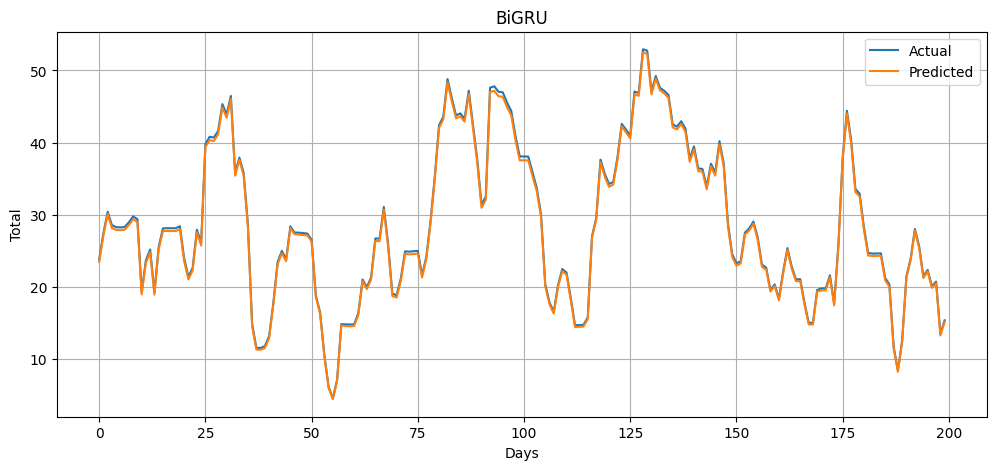

In [6]:

# --- Part 6: BiGRU ---
print("\n\n" + "=" * 60); print("PART 6: PROCEDURAL BIDIRECTIONAL GRU (BIGRU)"); print("=" * 60)
BIGRU_INPUT_DIM, BIGRU_HIDDEN_DIM, BIGRU_NUM_LAYERS, BIGRU_OUTPUT_DIM, BIGRU_DROPOUT = X_train.shape[2], 64, 1, 1, 0.0
BIGRU_EPOCHS, BIGRU_BATCH_SIZE, BIGRU_LEARNING_RATE = 20, 32, 0.001
bigru_layer = nn.GRU(BIGRU_INPUT_DIM, BIGRU_HIDDEN_DIM, BIGRU_NUM_LAYERS, batch_first=True, bidirectional=True, dropout=BIGRU_DROPOUT).to(device)
bigru_fc_layer = nn.Linear(BIGRU_HIDDEN_DIM * 2, BIGRU_OUTPUT_DIM).to(device); bigru_optimizer = torch.optim.Adam(itertools.chain(bigru_layer.parameters(), bigru_fc_layer.parameters()), lr=BIGRU_LEARNING_RATE)
bigru_criterion = nn.MSELoss(); bigru_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BIGRU_BATCH_SIZE, shuffle=True); loss_history['BiGRU'], val_loss_history['BiGRU'] = [], []
print("\n--- Starting BiGRU Model Training ---")
for epoch in range(BIGRU_EPOCHS):
    bigru_layer.train(); bigru_fc_layer.train(); running_loss = 0.0
    for xb, yb in bigru_train_loader:
        xb, yb = xb.to(device), yb.to(device); rnn_out, _ = bigru_layer(xb); pred = bigru_fc_layer(rnn_out[:, -1, :]); loss = bigru_criterion(pred, yb); bigru_optimizer.zero_grad(); loss.backward(); bigru_optimizer.step(); running_loss += loss.item()
    avg_epoch_loss = running_loss / len(bigru_train_loader); loss_history['BiGRU'].append(avg_epoch_loss)
    with torch.no_grad(): rnn_out, _ = bigru_layer(X_val.to(device)); val_pred = bigru_fc_layer(rnn_out[:, -1, :]); val_loss = bigru_criterion(val_pred, Y_val.to(device)); val_loss_history['BiGRU'].append(val_loss.item())
    print(f"BiGRU Epoch {epoch+1:2d}/{BIGRU_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss.item():.6f}")
print("--- BiGRU Training Complete ---")
with torch.no_grad(): rnn_out, _ = bigru_layer(X_test.to(device)); bigru_preds_rescaled = target_scaler.inverse_transform(bigru_fc_layer(rnn_out[:, -1, :]).cpu().numpy()); bigru_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())
bigru_r2, bigru_rmse, bigru_mae = r2_score(bigru_true_rescaled, bigru_preds_rescaled), np.sqrt(mean_squared_error(bigru_true_rescaled, bigru_preds_rescaled)), mean_absolute_error(bigru_true_rescaled, bigru_preds_rescaled)
r2_scores['BiGRU'], rmse_scores['BiGRU'], mae_scores['BiGRU'] = bigru_r2, bigru_rmse, bigru_mae
print(f"\nBiGRU Final R²: {bigru_r2:.4f}, RMSE: {bigru_rmse:.4f}, MAE: {bigru_mae:.4f}")
plt.figure(figsize=(12, 5)); plt.plot(bigru_true_rescaled[:200], label='Actual'); plt.plot(bigru_preds_rescaled[:200], label='Predicted'); plt.title('BiGRU');
plt.xlabel("Days")
plt.ylabel("Total")
plt.legend(); plt.grid(True); plt.show()





PART 7: PROCEDURAL 'PURE' GRAPH CONVOLUTIONAL NETWORK (GCN) - Procedural Version

--- Setting up GCN Model Parameters ---

--- Starting GCN Model Training ---
GCN Epoch  1/20 | Train Loss: 0.008386 | Val Loss: 0.002630
GCN Epoch  2/20 | Train Loss: 0.001455 | Val Loss: 0.001598
GCN Epoch  3/20 | Train Loss: 0.001170 | Val Loss: 0.001361
GCN Epoch  4/20 | Train Loss: 0.001007 | Val Loss: 0.001214
GCN Epoch  5/20 | Train Loss: 0.000846 | Val Loss: 0.001119
GCN Epoch  6/20 | Train Loss: 0.000714 | Val Loss: 0.000958
GCN Epoch  7/20 | Train Loss: 0.000615 | Val Loss: 0.000809
GCN Epoch  8/20 | Train Loss: 0.000509 | Val Loss: 0.000784
GCN Epoch  9/20 | Train Loss: 0.000447 | Val Loss: 0.000783
GCN Epoch 10/20 | Train Loss: 0.000389 | Val Loss: 0.000678
GCN Epoch 11/20 | Train Loss: 0.000353 | Val Loss: 0.000660
GCN Epoch 12/20 | Train Loss: 0.000322 | Val Loss: 0.000831
GCN Epoch 13/20 | Train Loss: 0.000305 | Val Loss: 0.000689
GCN Epoch 14/20 | Train Loss: 0.000286 | Val Loss: 0.000769

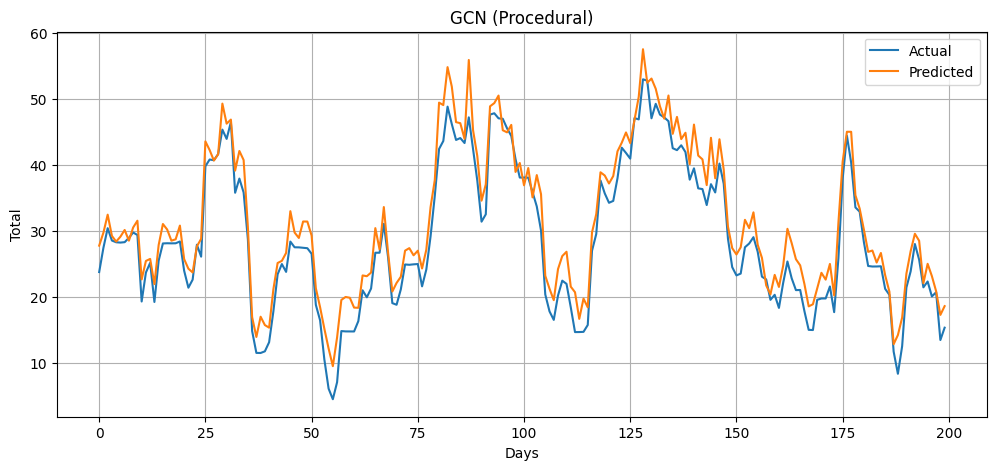

In [7]:
# ==============================================================================
# Part 7: Procedural "Pure" Graph Convolutional Network (GCN) - Procedural Version
# ==============================================================================
print("\n\n" + "=" * 60)
print("PART 7: PROCEDURAL 'PURE' GRAPH CONVOLUTIONAL NETWORK (GCN) - Procedural Version")
print("=" * 60)

print("\n--- Setting up GCN Model Parameters ---")
GCN_INPUT_DIM = X_train.shape[2]
GCN_HIDDEN_DIM = 128
GCN_OUTPUT_DIM = 1
GCN_DROPOUT = 0.3
GCN_EPOCHS = 20
GCN_BATCH_SIZE = 32
GCN_LEARNING_RATE = 0.0001

# Layers
gcn_linear1 = nn.Linear(GCN_INPUT_DIM, GCN_HIDDEN_DIM).to(device)
gcn_linear2 = nn.Linear(GCN_HIDDEN_DIM, GCN_HIDDEN_DIM).to(device)
fc_out_gcn = nn.Linear(GCN_HIDDEN_DIM, GCN_OUTPUT_DIM).to(device)
dropout_gcn = nn.Dropout(GCN_DROPOUT)

# Optimizer & Loss
gcn_params = list(gcn_linear1.parameters()) + list(gcn_linear2.parameters()) + list(fc_out_gcn.parameters())
gcn_optimizer = torch.optim.Adam(gcn_params, lr=GCN_LEARNING_RATE)
gcn_criterion = nn.MSELoss()
gcn_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=GCN_BATCH_SIZE, shuffle=True)

loss_history['GCN'], val_loss_history['GCN'] = [], []

# Forward Function
def forward_gcn(x, adj):
    gcn_features_over_time = []
    for t in range(x.size(1)):
        xt = x[:, t, :]
        xt = torch.matmul(xt, adj)
        xt = F.relu(gcn_linear1(xt))
        xt = F.relu(gcn_linear2(xt))
        xt = dropout_gcn(xt)
        gcn_features_over_time.append(xt.unsqueeze(1))
    x_gcn_seq = torch.cat(gcn_features_over_time, dim=1)
    last_step_features = x_gcn_seq[:, -1, :]
    return fc_out_gcn(last_step_features)

# Training Loop
print("\n--- Starting GCN Model Training ---")
for epoch in range(GCN_EPOCHS):
    gcn_linear1.train(); gcn_linear2.train(); fc_out_gcn.train()
    running_loss = 0.0
    for xb, yb in gcn_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = forward_gcn(xb, adj_tensor)
        loss = gcn_criterion(pred, yb)
        gcn_optimizer.zero_grad()
        loss.backward()
        gcn_optimizer.step()
        running_loss += loss.item()
    avg_epoch_loss = running_loss / len(gcn_train_loader)
    loss_history['GCN'].append(avg_epoch_loss)

    with torch.no_grad():
        val_pred = forward_gcn(X_val.to(device), adj_tensor)
        val_loss = gcn_criterion(val_pred, Y_val.to(device))
        val_loss_history['GCN'].append(val_loss.item())

    print(f"GCN Epoch {epoch+1:2d}/{GCN_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss.item():.6f}")

print("--- GCN Training Complete ---")

# Evaluation
with torch.no_grad():
    gcn_preds = forward_gcn(X_test.to(device), adj_tensor)
    gcn_preds_rescaled = target_scaler.inverse_transform(gcn_preds.cpu().numpy())
    gcn_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())

gcn_r2 = r2_score(gcn_true_rescaled, gcn_preds_rescaled)
gcn_rmse = np.sqrt(mean_squared_error(gcn_true_rescaled, gcn_preds_rescaled))
gcn_mae = mean_absolute_error(gcn_true_rescaled, gcn_preds_rescaled)
r2_scores['GCN'], rmse_scores['GCN'], mae_scores['GCN'] = gcn_r2, gcn_rmse, gcn_mae

print(f"\nGCN Final R²: {gcn_r2:.4f}, RMSE: {gcn_rmse:.4f}, MAE: {gcn_mae:.4f}")
plt.figure(figsize=(12, 5))
plt.plot(gcn_true_rescaled[:200], label='Actual')
plt.plot(gcn_preds_rescaled[:200], label='Predicted')
plt.title('GCN (Procedural)')
plt.xlabel("Days")
plt.ylabel("Total")
plt.legend()
plt.grid(True)
plt.show()




PART 10: PROCEDURAL HYBRID MODEL (TCN + GCN)

--- Starting Hybrid TCN-GCN Model Training ---
Hybrid TCN-GCN Epoch  1/20 | Train Loss: 0.002329 | Val Loss: 0.001121
Hybrid TCN-GCN Epoch  2/20 | Train Loss: 0.000565 | Val Loss: 0.001258
Hybrid TCN-GCN Epoch  3/20 | Train Loss: 0.000373 | Val Loss: 0.001228
Hybrid TCN-GCN Epoch  4/20 | Train Loss: 0.000273 | Val Loss: 0.001410
Hybrid TCN-GCN Epoch  5/20 | Train Loss: 0.000232 | Val Loss: 0.001484
Hybrid TCN-GCN Epoch  6/20 | Train Loss: 0.000209 | Val Loss: 0.001325
Hybrid TCN-GCN Epoch  7/20 | Train Loss: 0.000197 | Val Loss: 0.000866
Hybrid TCN-GCN Epoch  8/20 | Train Loss: 0.000192 | Val Loss: 0.000981
Hybrid TCN-GCN Epoch  9/20 | Train Loss: 0.000180 | Val Loss: 0.000686
Hybrid TCN-GCN Epoch 10/20 | Train Loss: 0.000176 | Val Loss: 0.000762
Hybrid TCN-GCN Epoch 11/20 | Train Loss: 0.000173 | Val Loss: 0.000692
Hybrid TCN-GCN Epoch 12/20 | Train Loss: 0.000165 | Val Loss: 0.000745
Hybrid TCN-GCN Epoch 13/20 | Train Loss: 0.000166 | V

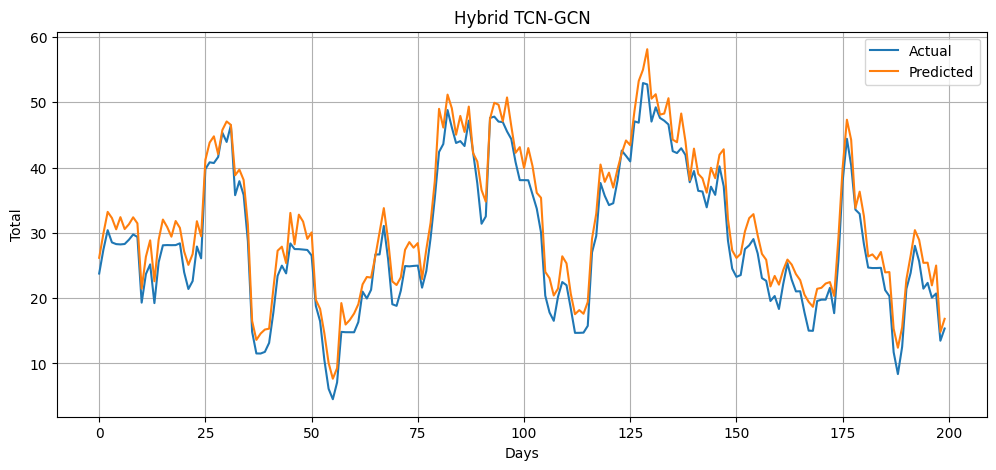

In [8]:
# ==============================================================================
# Part 10: PROCEDURAL HYBRID MODEL (TCN + GCN)
# ==============================================================================
print("\n\n" + "=" * 60)
print("PART 10: PROCEDURAL HYBRID MODEL (TCN + GCN)")
print("=" * 60)

HYBRID_INPUT_DIM, TCN_HIDDEN_DIM, GCN_HIDDEN_DIM, HYBRID_OUTPUT_DIM = X_train.shape[2], 64, 128, 1
KERNEL_SIZE, TCN_DROPOUT, HYBRID_DROPOUT = 3, 0.2, 0.3
HYBRID_EPOCHS, HYBRID_BATCH_SIZE, HYBRID_LR = 20, 32, 0.001

# TCN Component
tcn_layer = nn.Sequential(
    nn.Conv1d(HYBRID_INPUT_DIM, TCN_HIDDEN_DIM, kernel_size=KERNEL_SIZE, padding=(KERNEL_SIZE - 1) // 2),
    nn.ReLU(),
    nn.Dropout(TCN_DROPOUT)
).to(device)

# GCN Component
tcn_gcn1 = nn.Linear(HYBRID_INPUT_DIM, GCN_HIDDEN_DIM).to(device)
tcn_gcn2 = nn.Linear(GCN_HIDDEN_DIM, GCN_HIDDEN_DIM).to(device)
tcn_gcn_dropout = nn.Dropout(HYBRID_DROPOUT)

# Output Layer
tcn_gcn_fc = nn.Linear(TCN_HIDDEN_DIM + GCN_HIDDEN_DIM, HYBRID_OUTPUT_DIM).to(device)

# Optimizer & Loss
tcn_gcn_params = list(tcn_layer.parameters()) + list(tcn_gcn1.parameters()) + list(tcn_gcn2.parameters()) + list(tcn_gcn_fc.parameters())
tcn_gcn_optimizer = torch.optim.Adam(tcn_gcn_params, lr=HYBRID_LR)
tcn_gcn_criterion = nn.MSELoss()
tcn_gcn_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=HYBRID_BATCH_SIZE, shuffle=True)
loss_history['Hybrid_TCN_GCN'], val_loss_history['Hybrid_TCN_GCN'] = [], []

print("\n--- Starting Hybrid TCN-GCN Model Training ---")
for epoch in range(HYBRID_EPOCHS):
    tcn_layer.train(); tcn_gcn1.train(); tcn_gcn2.train(); tcn_gcn_fc.train(); running_loss = 0.0
    for xb, yb in tcn_gcn_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        tcn_in = xb.permute(0, 2, 1)
        tcn_feat = tcn_layer(tcn_in)
        tcn_feat_last = tcn_feat[:, :, -1]

        gcn_feats = []
        for t in range(xb.size(1)):
            xt = xb[:, t, :]
            xt = torch.matmul(xt, adj_tensor)
            xt = F.relu(tcn_gcn1(xt))
            xt = F.relu(tcn_gcn2(xt))
            xt = tcn_gcn_dropout(xt)
            gcn_feats.append(xt.unsqueeze(1))
        gcn_seq = torch.cat(gcn_feats, dim=1)
        gcn_feat = gcn_seq[:, -1, :]

        combined = torch.cat([tcn_feat_last, gcn_feat], dim=1)
        pred = tcn_gcn_fc(combined)
        loss = tcn_gcn_criterion(pred, yb)
        tcn_gcn_optimizer.zero_grad(); loss.backward(); tcn_gcn_optimizer.step(); running_loss += loss.item()

    avg_epoch_loss = running_loss / len(tcn_gcn_train_loader)
    loss_history['Hybrid_TCN_GCN'].append(avg_epoch_loss)

    with torch.no_grad():
        tcn_val_in = X_val.permute(0, 2, 1).to(device)
        tcn_val_feat = tcn_layer(tcn_val_in)
        tcn_val_last = tcn_val_feat[:, :, -1]

        gcn_val_feats = []
        for t in range(X_val.size(1)):
            xt = X_val[:, t, :].to(device)
            xt = torch.matmul(xt, adj_tensor)
            xt = F.relu(tcn_gcn1(xt))
            xt = F.relu(tcn_gcn2(xt))
            xt = tcn_gcn_dropout(xt)
            gcn_val_feats.append(xt.unsqueeze(1))
        gcn_val_seq = torch.cat(gcn_val_feats, dim=1)
        gcn_val_feat = gcn_val_seq[:, -1, :]

        val_combined = torch.cat([tcn_val_last, gcn_val_feat], dim=1)
        val_pred = tcn_gcn_fc(val_combined)
        val_loss = tcn_gcn_criterion(val_pred, Y_val.to(device))
        val_loss_history['Hybrid_TCN_GCN'].append(val_loss.item())

    print(f"Hybrid TCN-GCN Epoch {epoch+1:2d}/{HYBRID_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss.item():.6f}")

print("--- Hybrid TCN-GCN Training Complete ---")

# Final Evaluation
with torch.no_grad():
    tcn_test_in = X_test.permute(0, 2, 1).to(device)
    tcn_test_feat = tcn_layer(tcn_test_in)
    tcn_test_last = tcn_test_feat[:, :, -1]

    gcn_test_feats = []
    for t in range(X_test.size(1)):
        xt = X_test[:, t, :].to(device)
        xt = torch.matmul(xt, adj_tensor)
        xt = F.relu(tcn_gcn1(xt))
        xt = F.relu(tcn_gcn2(xt))
        xt = tcn_gcn_dropout(xt)
        gcn_test_feats.append(xt.unsqueeze(1))
    gcn_test_seq = torch.cat(gcn_test_feats, dim=1)
    gcn_test_feat = gcn_test_seq[:, -1, :]

    final_combined = torch.cat([tcn_test_last, gcn_test_feat], dim=1)
    hybrid_preds = tcn_gcn_fc(final_combined)

    hybrid_preds_rescaled = target_scaler.inverse_transform(hybrid_preds.cpu().numpy())
    hybrid_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())

hybrid_r2 = r2_score(hybrid_true_rescaled, hybrid_preds_rescaled)
hybrid_rmse = np.sqrt(mean_squared_error(hybrid_true_rescaled, hybrid_preds_rescaled))
hybrid_mae = mean_absolute_error(hybrid_true_rescaled, hybrid_preds_rescaled)

r2_scores['Hybrid_TCN_GCN'] = hybrid_r2
rmse_scores['Hybrid_TCN_GCN'] = hybrid_rmse
mae_scores['Hybrid_TCN_GCN'] = hybrid_mae

print(f"\nHybrid TCN-GCN Final R²: {hybrid_r2:.4f}, RMSE: {hybrid_rmse:.4f}, MAE: {hybrid_mae:.4f}")
plt.figure(figsize=(12, 5))
plt.plot(hybrid_true_rescaled[:200], label='Actual')
plt.plot(hybrid_preds_rescaled[:200], label='Predicted')
plt.title('Hybrid TCN-GCN')
plt.xlabel("Days")
plt.ylabel("Total")
plt.legend()
plt.grid(True)
plt.show()




PART 9: PROCEDURAL HYBRID MODEL (GRU + GCN)

--- Starting Hybrid GRU-GCN Model Training ---
Hybrid GRU-GCN Epoch  1/20 | Train Loss: 0.001282 | Val Loss: 0.000351
Hybrid GRU-GCN Epoch  2/20 | Train Loss: 0.000024 | Val Loss: 0.000294
Hybrid GRU-GCN Epoch  3/20 | Train Loss: 0.000002 | Val Loss: 0.000297
Hybrid GRU-GCN Epoch  4/20 | Train Loss: 0.000001 | Val Loss: 0.000309
Hybrid GRU-GCN Epoch  5/20 | Train Loss: 0.000001 | Val Loss: 0.000286
Hybrid GRU-GCN Epoch  6/20 | Train Loss: 0.000001 | Val Loss: 0.000282
Hybrid GRU-GCN Epoch  7/20 | Train Loss: 0.000002 | Val Loss: 0.000270
Hybrid GRU-GCN Epoch  8/20 | Train Loss: 0.000001 | Val Loss: 0.000281
Hybrid GRU-GCN Epoch  9/20 | Train Loss: 0.000001 | Val Loss: 0.000305
Hybrid GRU-GCN Epoch 10/20 | Train Loss: 0.000001 | Val Loss: 0.000328
Hybrid GRU-GCN Epoch 11/20 | Train Loss: 0.000001 | Val Loss: 0.000316
Hybrid GRU-GCN Epoch 12/20 | Train Loss: 0.000001 | Val Loss: 0.000325
Hybrid GRU-GCN Epoch 13/20 | Train Loss: 0.000001 | Va

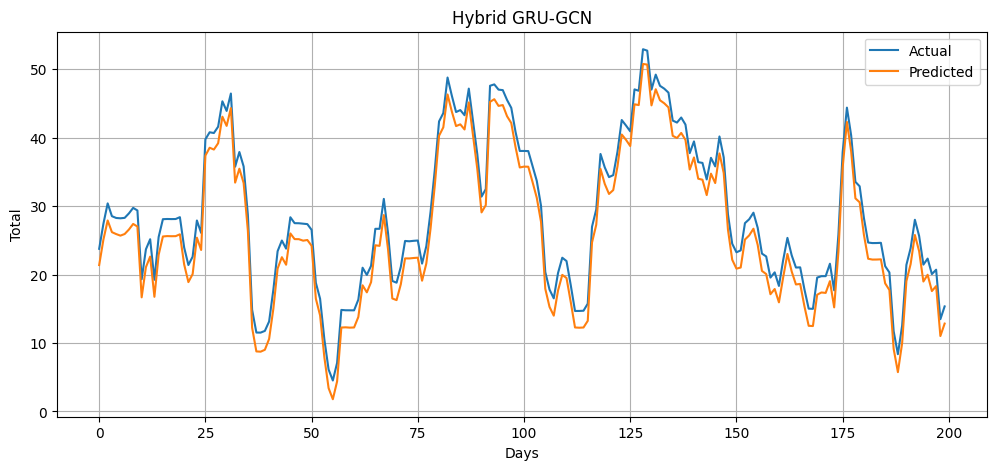

In [9]:
# ==============================================================================
# Part 9: PROCEDURAL HYBRID MODEL (GRU + GCN)
# ==============================================================================

print("\n\n" + "=" * 60); print("PART 9: PROCEDURAL HYBRID MODEL (GRU + GCN)"); print("=" * 60)

HYBRID_INPUT_DIM, GRU_HIDDEN_DIM, GCN_HIDDEN_DIM, HYBRID_OUTPUT_DIM = X_train.shape[2], 64, 128, 1
GRU_NUM_LAYERS, HYBRID_DROPOUT = 1, 0.3
HYBRID_EPOCHS, HYBRID_BATCH_SIZE, HYBRID_LR = 20, 32, 0.001

# Define Layers
hybrid_gru_layer = nn.GRU(HYBRID_INPUT_DIM, GRU_HIDDEN_DIM, GRU_NUM_LAYERS, batch_first=True).to(device)
hybrid_gcn1 = nn.Linear(HYBRID_INPUT_DIM, GCN_HIDDEN_DIM).to(device)
hybrid_gcn2 = nn.Linear(GCN_HIDDEN_DIM, GCN_HIDDEN_DIM).to(device)
hybrid_dropout = nn.Dropout(HYBRID_DROPOUT)
hybrid_fc_layer = nn.Linear(GRU_HIDDEN_DIM + GCN_HIDDEN_DIM, HYBRID_OUTPUT_DIM).to(device)

# Optimizer & Loss
hybrid_params = list(hybrid_gru_layer.parameters()) + list(hybrid_gcn1.parameters()) + list(hybrid_gcn2.parameters()) + list(hybrid_fc_layer.parameters())
hybrid_optimizer = torch.optim.Adam(hybrid_params, lr=HYBRID_LR)
hybrid_criterion = nn.MSELoss()
hybrid_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=HYBRID_BATCH_SIZE, shuffle=True)
loss_history['Hybrid_GRU_GCN'], val_loss_history['Hybrid_GRU_GCN'] = [], []

print("\n--- Starting Hybrid GRU-GCN Model Training ---")
for epoch in range(HYBRID_EPOCHS):
    hybrid_gru_layer.train(); hybrid_gcn1.train(); hybrid_gcn2.train(); hybrid_fc_layer.train(); running_loss = 0.0
    for xb, yb in hybrid_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        # GRU path
        gru_out, _ = hybrid_gru_layer(xb)
        gru_feat = gru_out[:, -1, :]
        # GCN path over time
        gcn_feats = []
        for t in range(xb.size(1)):
            xt = xb[:, t, :]
            xt = torch.matmul(xt, adj_tensor)
            xt = F.relu(hybrid_gcn1(xt))
            xt = F.relu(hybrid_gcn2(xt))
            xt = hybrid_dropout(xt)
            gcn_feats.append(xt.unsqueeze(1))
        gcn_seq = torch.cat(gcn_feats, dim=1)
        gcn_feat = gcn_seq[:, -1, :]
        # Combine and predict
        combined = torch.cat([gru_feat, gcn_feat], dim=1)
        pred = hybrid_fc_layer(combined)
        loss = hybrid_criterion(pred, yb)
        hybrid_optimizer.zero_grad(); loss.backward(); hybrid_optimizer.step(); running_loss += loss.item()
    avg_epoch_loss = running_loss / len(hybrid_train_loader)
    loss_history['Hybrid_GRU_GCN'].append(avg_epoch_loss)

    # Validation
    with torch.no_grad():
        val_gru, _ = hybrid_gru_layer(X_val.to(device))
        val_gru_feat = val_gru[:, -1, :]
        val_gcn_feats = []
        for t in range(X_val.size(1)):
            xt = X_val[:, t, :].to(device)
            xt = torch.matmul(xt, adj_tensor)
            xt = F.relu(hybrid_gcn1(xt))
            xt = F.relu(hybrid_gcn2(xt))
            xt = hybrid_dropout(xt)
            val_gcn_feats.append(xt.unsqueeze(1))
        val_gcn_seq = torch.cat(val_gcn_feats, dim=1)
        val_gcn_feat = val_gcn_seq[:, -1, :]
        val_combined = torch.cat([val_gru_feat, val_gcn_feat], dim=1)
        val_pred = hybrid_fc_layer(val_combined)
        val_loss = hybrid_criterion(val_pred, Y_val.to(device))
        val_loss_history['Hybrid_GRU_GCN'].append(val_loss.item())

    print(f"Hybrid GRU-GCN Epoch {epoch+1:2d}/{HYBRID_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss.item():.6f}")

print("--- Hybrid GRU-GCN Training Complete ---")

# Evaluation on test
with torch.no_grad():
    test_gru, _ = hybrid_gru_layer(X_test.to(device))
    test_gru_feat = test_gru[:, -1, :]
    test_gcn_feats = []
    for t in range(X_test.size(1)):
        xt = X_test[:, t, :].to(device)
        xt = torch.matmul(xt, adj_tensor)
        xt = F.relu(hybrid_gcn1(xt))
        xt = F.relu(hybrid_gcn2(xt))
        xt = hybrid_dropout(xt)
        test_gcn_feats.append(xt.unsqueeze(1))
    test_gcn_seq = torch.cat(test_gcn_feats, dim=1)
    test_gcn_feat = test_gcn_seq[:, -1, :]
    test_combined = torch.cat([test_gru_feat, test_gcn_feat], dim=1)
    hybrid_test_pred = hybrid_fc_layer(test_combined)

    hybrid_preds_rescaled = target_scaler.inverse_transform(hybrid_test_pred.cpu().numpy())
    hybrid_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())

hybrid_r2 = r2_score(hybrid_true_rescaled, hybrid_preds_rescaled)
hybrid_rmse = np.sqrt(mean_squared_error(hybrid_true_rescaled, hybrid_preds_rescaled))
hybrid_mae = mean_absolute_error(hybrid_true_rescaled, hybrid_preds_rescaled)

r2_scores['Hybrid_GRU_GCN'] = hybrid_r2
rmse_scores['Hybrid_GRU_GCN'] = hybrid_rmse
mae_scores['Hybrid_GRU_GCN'] = hybrid_mae

print(f"\nHybrid GRU-GCN Final R²: {hybrid_r2:.4f}, RMSE: {hybrid_rmse:.4f}, MAE: {hybrid_mae:.4f}")
plt.figure(figsize=(12, 5))
plt.plot(hybrid_true_rescaled[:200], label='Actual')
plt.plot(hybrid_preds_rescaled[:200], label='Predicted')
plt.title('Hybrid GRU-GCN')
plt.xlabel("Days")
plt.ylabel("Total")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# ==============================================================================
# Part 10: Final Metrics Comparison (Including Hybrids)
# ==============================================================================

print("\n\n" + "=" * 60)
print("📊 Final Metrics Comparison (Including Hybrid Models) 📊")
print("=" * 60)
print(f"{'Model':<20} | {'R² Score':>10} | {'RMSE':>10} | {'MAE':>10}")
print("-" * 60)

model_order = [
    'TCN', 'LSTM', 'BiLSTM', 'GRU', 'BiGRU', 'GCN',
    'Hybrid_TCN_GCN',               # TCN-GCN
    'Hybrid_GRU_GCN'        # GRU-GCN
]

for model_name in model_order:
    r2 = r2_scores.get(model_name, float('nan'))
    rmse = rmse_scores.get(model_name, float('nan'))
    mae = mae_scores.get(model_name, float('nan'))
    print(f"{model_name:<20} | {r2:>10.4f} | {rmse:>10.4f} | {mae:>10.4f}")

print("=" * 60)




📊 Final Metrics Comparison (Including Hybrid Models) 📊
Model                |   R² Score |       RMSE |        MAE
------------------------------------------------------------
TCN                  |     0.9967 |     0.5934 |     0.4770
LSTM                 |     0.9925 |     0.8974 |     0.8742
BiLSTM               |     0.9463 |     2.4090 |     2.4066
GRU                  |     0.7858 |     4.8094 |     4.8076
BiGRU                |     0.9988 |     0.3638 |     0.3421
GCN                  |     0.8809 |     3.5866 |     3.1986
Hybrid_TCN_GCN       |     0.9163 |     3.0068 |     2.7193
Hybrid_GRU_GCN       |     0.9424 |     2.4931 |     2.4892




PART 10: COMPARATIVE TRAINING LOSS CURVES
Displaying the comparative training loss graph. Close the plot to continue.


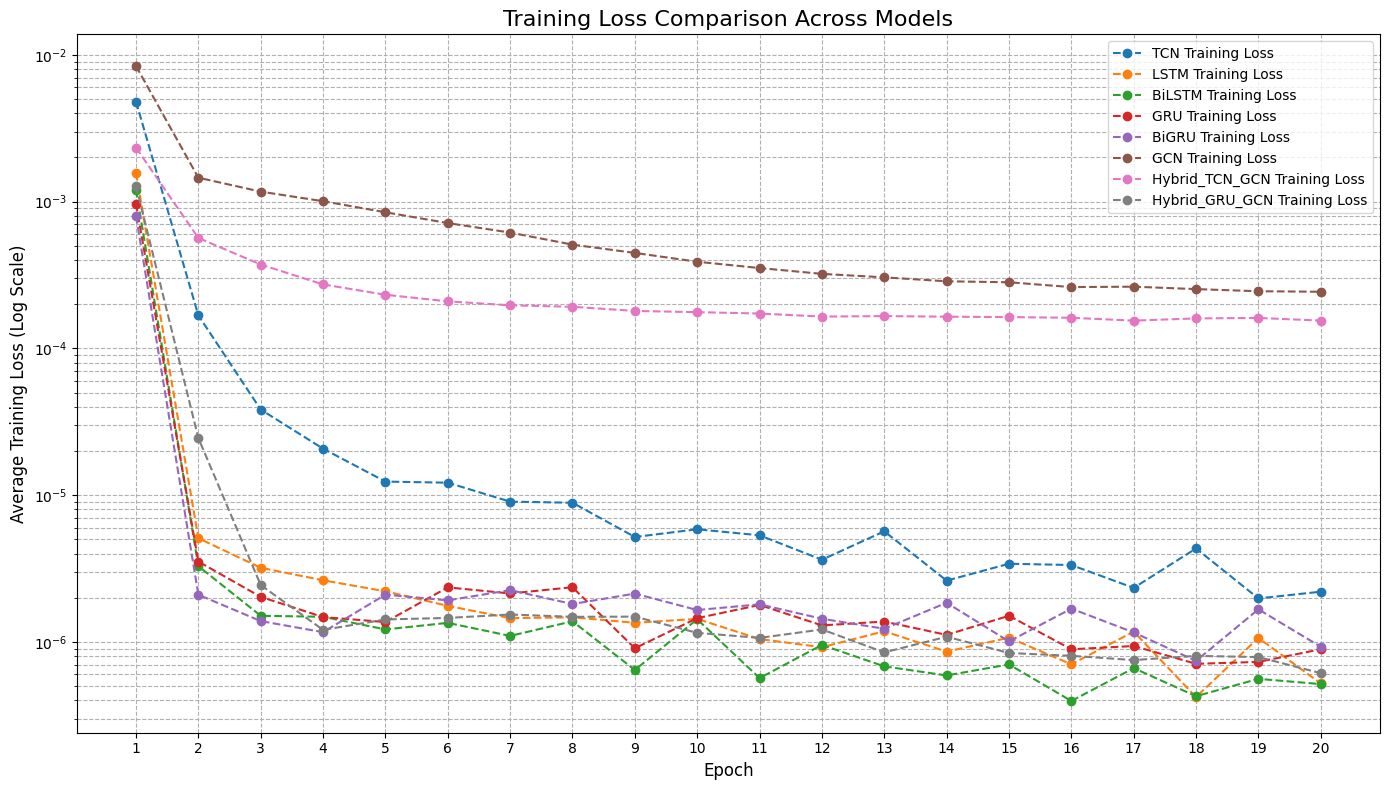

In [13]:
# ==============================================================================
# Part 10: Comparative Training Loss Graph
# ==============================================================================
print("\n\n" + "=" * 60); print("PART 10: COMPARATIVE TRAINING LOSS CURVES"); print("=" * 60)
plt.figure(figsize=(14, 8))

# Extend model order to include hybrid models explicitly
plot_models = model_order + ['Hybrid_TCN_GCN', 'Hybrid_GRU_GCN']

for model_name, losses in loss_history.items():
    if model_name in plot_models:
        plt.plot(range(1, len(losses) + 1), losses, label=f'{model_name} Training Loss', marker='o', linestyle='--')

plt.title('Training Loss Comparison Across Models', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Training Loss (Log Scale)', fontsize=12)
plt.legend()
plt.grid(True, which="both", ls="--")
plt.xticks(range(1, max([len(l) for l in loss_history.values() if len(l) > 0]) + 1))
plt.yscale('log')
plt.tight_layout()
print("Displaying the comparative training loss graph. Close the plot to continue.")
plt.show()




PART 11: PER-MODEL TRAINING VS. VALIDATION LOSS


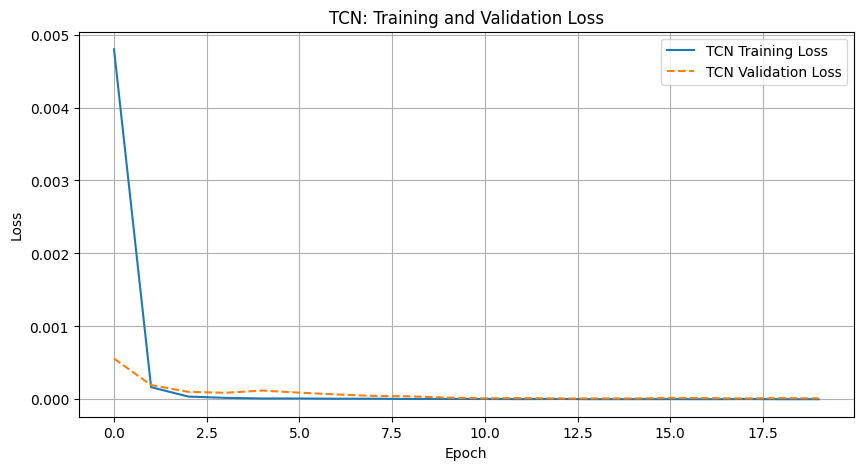

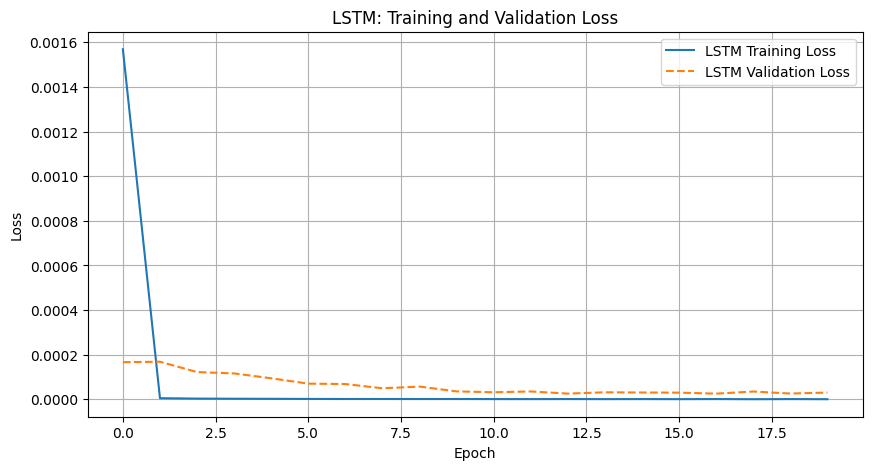

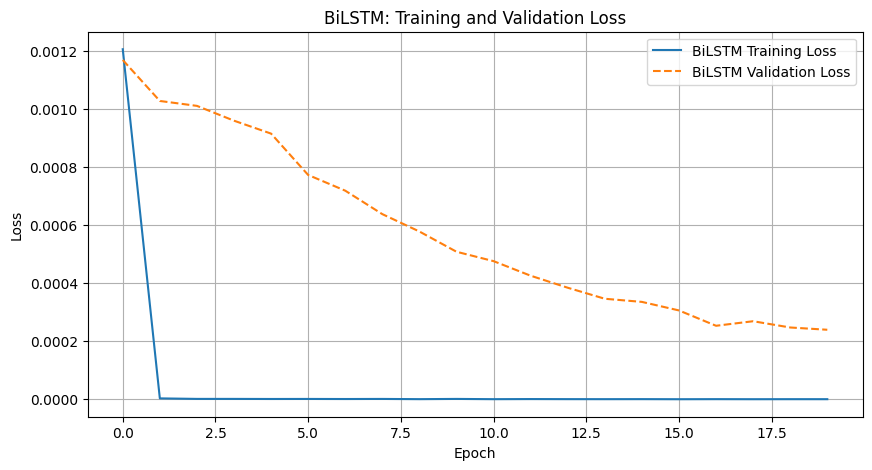

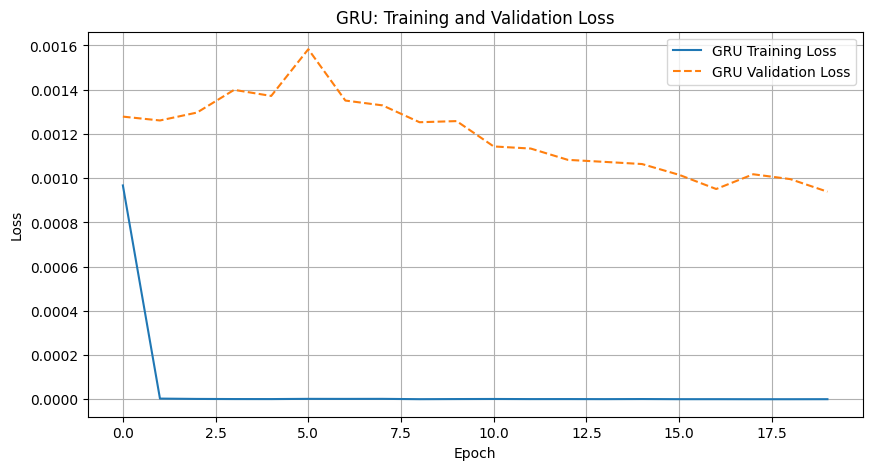

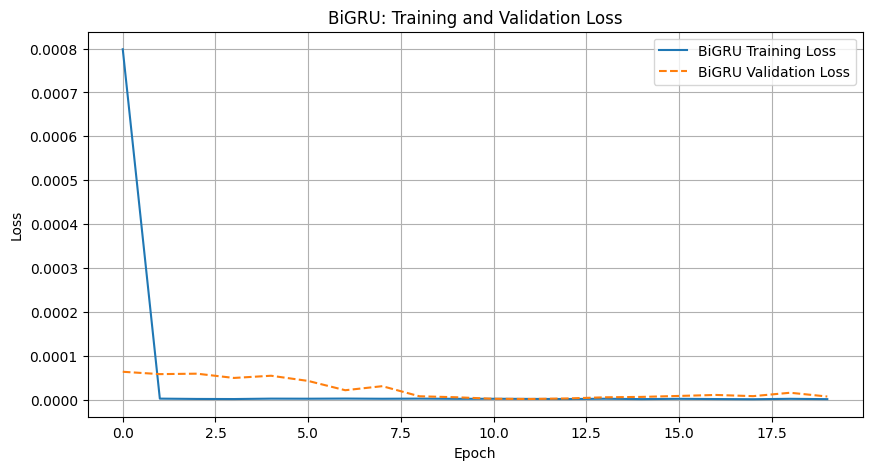

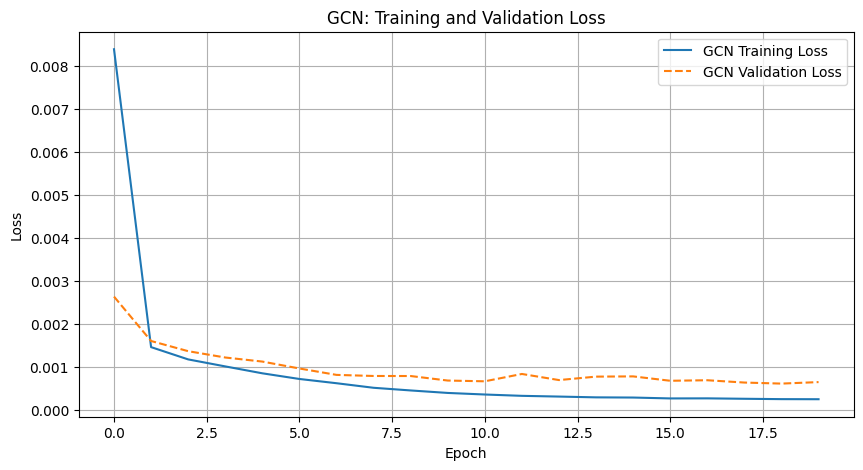

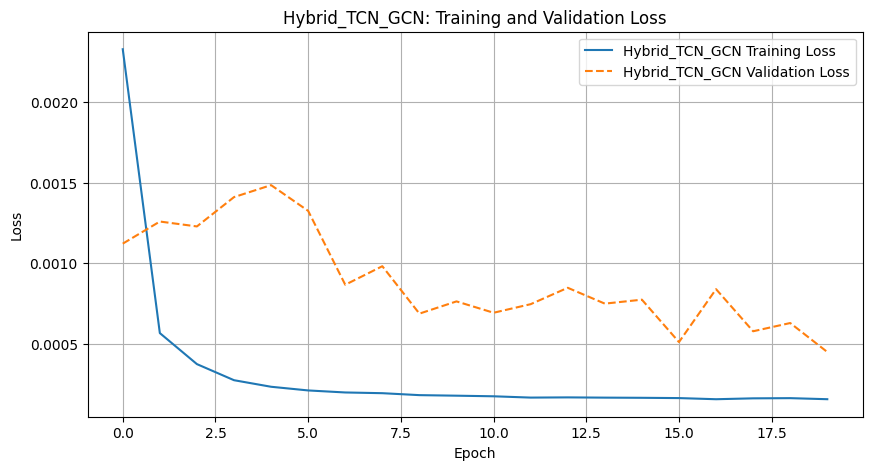

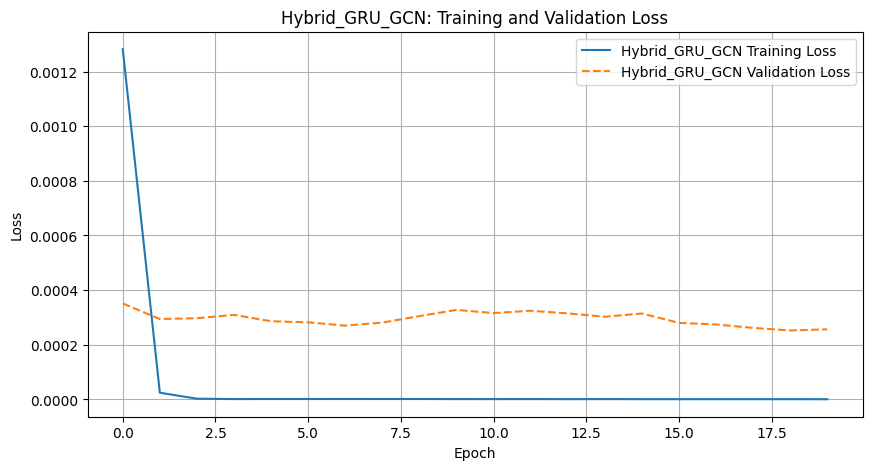


All analysis and plotting complete.


In [14]:
# ==============================================================================
# Part 11: Per-Model Training vs. Validation Loss Graphs
# ==============================================================================
print("\n\n" + "=" * 60)
print("PART 11: PER-MODEL TRAINING VS. VALIDATION LOSS")
print("=" * 60)

# Extend model order to include hybrid models with correct keys
plot_models = model_order 

for model_name in plot_models:
    if model_name in loss_history and model_name in val_loss_history:
        plt.figure(figsize=(10, 5))
        plt.plot(loss_history[model_name], label=f"{model_name} Training Loss")
        plt.plot(val_loss_history[model_name], label=f"{model_name} Validation Loss", linestyle='--')
        plt.title(f"{model_name}: Training and Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

print("\nAll analysis and plotting complete.")
